In [7]:
!apt-get install -y swig
!pip install gymnasium[box2d]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


# **Exploración y Explotación en Aprendizaje por Refuerzo: Comparación de Métodos en el Entorno CarRacing-v3**

En este cuadernillo de Colab, implementamos y comparamos cinco métodos de aprendizaje por refuerzo que abordan el dilema entre exploración y explotación: ε-greedy, ε-greedy decreciente, UCB, Gradient Bandit y Optimistic Initial Values. Utilizamos el entorno CarRacing-v3 de Gymnasium, donde un agente controla un coche en una pista con acciones discretas (girar izquierda/acelerar, girar derecha/acelerar, acelerar recto, frenar, nada). El objetivo es evaluar cómo cada método aprende a maximizar la recompensa a lo largo del tiempo, simulando valores óptimos q*(a) con ruido. Mostraremos gráficas individuales por método durante el entrenamiento y una gráfica comparativa final, incluyendo la diferencia de rendimiento, para analizar su efectividad y justificar el mejor enfoque.

In [15]:
# === CONFIGURACIÓN INICIAL ===
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from scipy.special import softmax
from collections import defaultdict

In [16]:
# Parámetros generales
np.random.seed(42)  # Semilla para reproducibilidad
partidas = 50       # Reducido a 50 para pruebas rápidas
turnos = 20         # Reducido a 20 para pruebas rápidas

In [18]:
# Configuración del entorno CarRacing-v3
env = gym.make("CarRacing-v3", render_mode=None, continuous=False)  # Modo discreto
action_space = [0, 1, 2, 3, 4]  # Índices de acciones discretas de CarRacing-v3
action_mapping = [
    (-1, 1, 0),  # 0: Girar izquierda + acelerar
    (1, 1, 0),   # 1: Girar derecha + acelerar
    (0, 1, 0),   # 2: Acelerar recto
    (0, 0, 1),   # 3: Frenar
    (0, 0, 0)    # 4: No hacer nada
]
n_actions = len(action_space)

# Generar valores óptimos q*(a) para cada acción (recompensa esperada)
mu, sigma = 0, 1  # Media y desviación estándar para simular q*(a)
q = {k: np.random.normal(mu, sigma) for k in range(n_actions)}
# Estructuras para almacenar resultados (5 métodos)
recompensas_medias = np.zeros((5, turnos))  # ε-greedy, ε-decay, UCB, Gradient, Optimistic
acciones_optimas = np.zeros((5, turnos))   # Proporción de acciones óptimas

In [19]:
# === DEFINICIÓN DE MÉTODOS Y HIPERPARÁMETROS ===
# ε-greedy
epsilon = 0.1      # Solo un valor para simplificar
alpha_eg = 0.5
recompensas_eg = np.zeros(turnos)
acciones_optimas_eg = np.zeros(turnos)

# ε-greedy Decreciente
epsilon_inicial = 0.1
alpha_eg_decay = 0.5
recompensas_eg_decay = np.zeros(turnos)
acciones_optimas_eg_decay = np.zeros(turnos)

# UCB
c_ucb = 2.0
alpha_ucb = 0.5
recompensas_ucb = np.zeros(turnos)
acciones_optimas_ucb = np.zeros(turnos)

# Gradient Bandit
alpha_grad = 0.1
baseline = True
recompensas_grad = np.zeros(turnos)
acciones_optimas_grad = np.zeros(turnos)

# Optimistic Initial Values
Q_init = 5.0
alpha_opt = 0.5
recompensas_opt = np.zeros(turnos)
acciones_optimas_opt = np.zeros(turnos)

# E-GREEDY

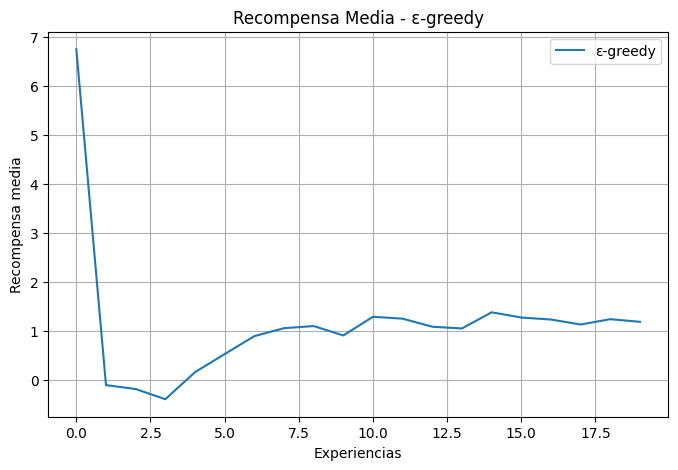

In [20]:
# === ENTRENAMIENTO PASO A PASO ===
# Paso 1: Inicialización y ejecución de episodios para cada método
for ej in range(partidas):
    mejor_accion = max(q, key=q.get)

    # Paso 1.1: Método ε-greedy
    Q = {k: 0 for k in range(n_actions)}
    acciones = {k: 0 for k in range(n_actions)}
    state, _ = env.reset()
    for exp in range(turnos):
        if np.random.uniform(0, 1) < epsilon:
            a = np.random.randint(n_actions)
        else:
            maxQ = -100
            for j in range(n_actions):
                if Q[j] > maxQ:
                    maxQ = Q[j]
                    a = j
        acciones[a] += 1
        next_state, recompensa, terminated, truncated, _ = env.step(action_space[a])
        recompensa += np.random.normal(q[a], sigma)
        Q[a] += alpha_eg * (recompensa - Q[a])
        recompensas_eg[exp] += recompensa
        acciones_optimas_eg[exp] += (a == mejor_accion)
        state = next_state
        if terminated or truncated:
            break
    recompensas_medias[0] += recompensas_eg
    acciones_optimas[0] += acciones_optimas_eg
    # Gráfica individual para ε-greedy (promedio acumulado)
    if ej == partidas - 1:
        plt.figure(figsize=(8, 5))
        plt.plot(recompensas_eg / partidas, label='ε-greedy')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Experiencias')
        plt.ylabel('Recompensa media')
        plt.title('Recompensa Media - ε-greedy')
        plt.show()

# ε-greedy Decreciente

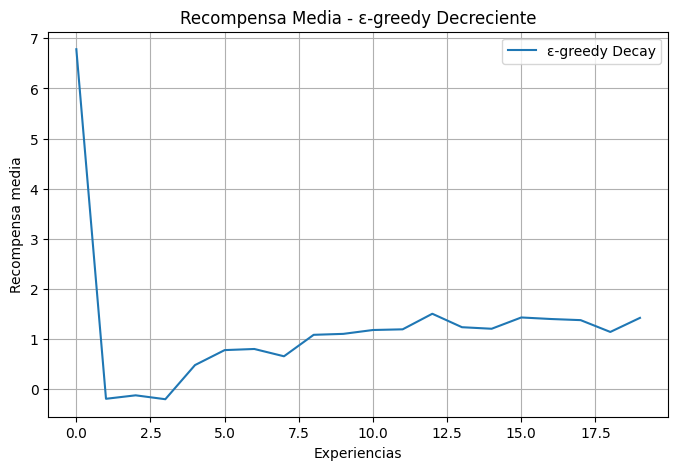

In [22]:
for ej in range(partidas):
    mejor_accion = max(q, key=q.get)
# Paso 1.2: Método ε-greedy Decreciente
    Q = {k: 0 for k in range(n_actions)}
    acciones = {k: 0 for k in range(n_actions)}
    state, _ = env.reset()
    for exp in range(turnos):
        e = epsilon_inicial * (1 - exp / turnos)
        if np.random.uniform(0, 1) < e:
            a = np.random.randint(n_actions)
        else:
            maxQ = -100
            for j in range(n_actions):
                if Q[j] > maxQ:
                    maxQ = Q[j]
                    a = j
        acciones[a] += 1
        next_state, recompensa, terminated, truncated, _ = env.step(action_space[a])
        recompensa += np.random.normal(q[a], sigma)
        Q[a] += alpha_eg_decay * (recompensa - Q[a])
        recompensas_eg_decay[exp] += recompensa
        acciones_optimas_eg_decay[exp] += (a == mejor_accion)
        state = next_state
        if terminated or truncated:
            break
    recompensas_medias[1] += recompensas_eg_decay
    acciones_optimas[1] += acciones_optimas_eg_decay
    # Gráfica individual para ε-greedy Decreciente (promedio acumulado)
    if ej == partidas - 1:
        plt.figure(figsize=(8, 5))
        plt.plot(recompensas_eg_decay / partidas, label='ε-greedy Decay')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Experiencias')
        plt.ylabel('Recompensa media')
        plt.title('Recompensa Media - ε-greedy Decreciente')
        plt.show()

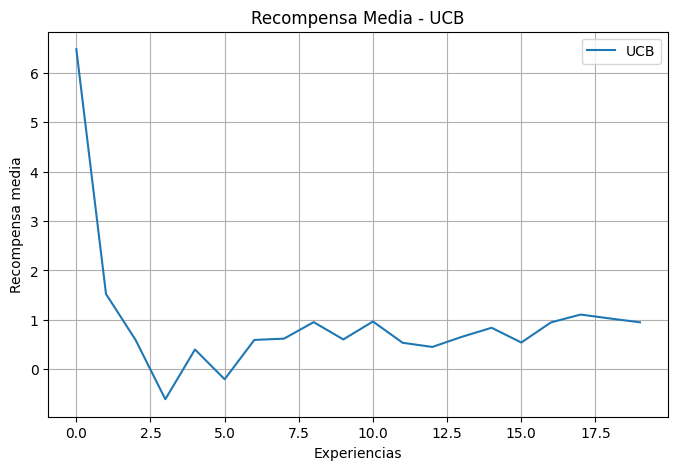

In [24]:
for ej in range(partidas):
    mejor_accion = max(q, key=q.get)
# Paso 1.3: Método UCB
    Q = {k: 0 for k in range(n_actions)}
    acciones = {k: 0 for k in range(n_actions)}
    t = 0
    state, _ = env.reset()
    for exp in range(turnos):
        t += 1
        ucb_values = {k: Q[k] + c_ucb * np.sqrt(np.log(t) / (acciones[k] + 1e-5)) for k in range(n_actions)}
        a = max(ucb_values, key=ucb_values.get)
        acciones[a] += 1
        next_state, recompensa, terminated, truncated, _ = env.step(action_space[a])
        recompensa += np.random.normal(q[a], sigma)
        Q[a] += alpha_ucb * (recompensa - Q[a])
        recompensas_ucb[exp] += recompensa
        acciones_optimas_ucb[exp] += (a == mejor_accion)
        state = next_state
        if terminated or truncated:
            break
    recompensas_medias[2] += recompensas_ucb
    acciones_optimas[2] += acciones_optimas_ucb
    # Gráfica individual para UCB (promedio acumulado)
    if ej == partidas - 1:
        plt.figure(figsize=(8, 5))
        plt.plot(recompensas_ucb / partidas, label='UCB')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Experiencias')
        plt.ylabel('Recompensa media')
        plt.title('Recompensa Media - UCB')
        plt.show()

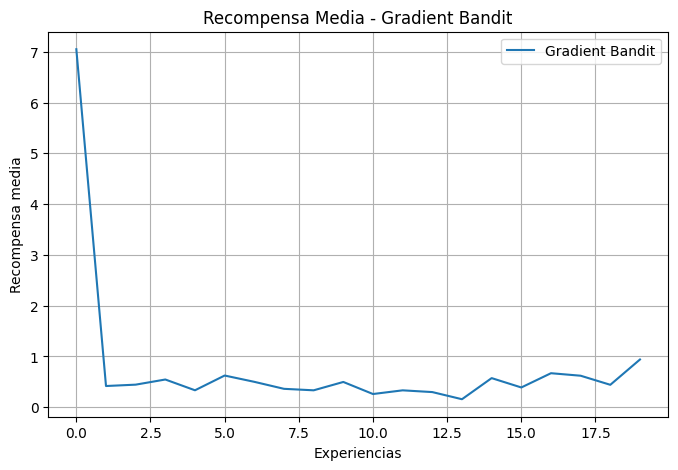

In [25]:
for ej in range(partidas):
    mejor_accion = max(q, key=q.get)
    # Paso 1.4: Método Gradient Bandit
    H = {k: 0 for k in range(n_actions)}
    acciones = {k: 0 for k in range(n_actions)}
    recompensa_total = 0
    n_recompensas = 0
    state, _ = env.reset()
    for exp in range(turnos):
        probs = softmax([H[k] for k in range(n_actions)])
        a = np.random.choice(n_actions, p=probs)
        acciones[a] += 1
        next_state, recompensa, terminated, truncated, _ = env.step(action_space[a])
        recompensa += np.random.normal(q[a], sigma)
        recompensa_total += recompensa
        n_recompensas += 1
        baseline_val = recompensa_total / n_recompensas if baseline and n_recompensas > 0 else 0
        for k in range(n_actions):
            if k == a:
                H[k] += alpha_grad * (recompensa - baseline_val) * (1 - probs[k])
            else:
                H[k] -= alpha_grad * (recompensa - baseline_val) * probs[k]
        recompensas_grad[exp] += recompensa
        acciones_optimas_grad[exp] += (a == mejor_accion)
        state = next_state
        if terminated or truncated:
            break
    recompensas_medias[3] += recompensas_grad
    acciones_optimas[3] += acciones_optimas_grad
    # Gráfica individual para Gradient Bandit (promedio acumulado)
    if ej == partidas - 1:
        plt.figure(figsize=(8, 5))
        plt.plot(recompensas_grad / partidas, label='Gradient Bandit')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Experiencias')
        plt.ylabel('Recompensa media')
        plt.title('Recompensa Media - Gradient Bandit')
        plt.show()

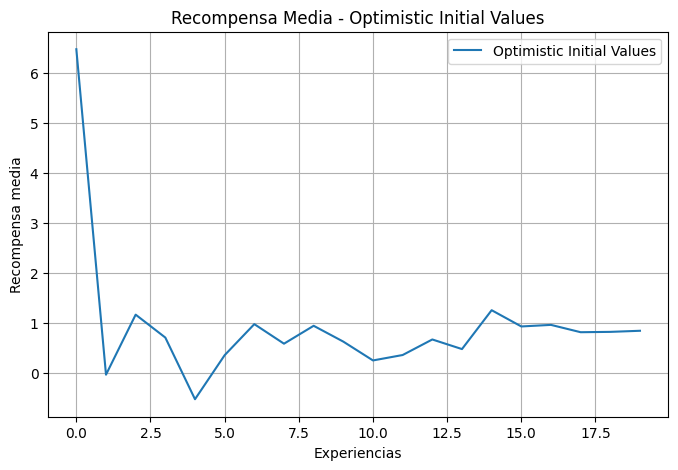

In [26]:
for ej in range(partidas):
    mejor_accion = max(q, key=q.get)
    # Paso 1.5: Método Optimistic Initial Values
    Q = {k: Q_init for k in range(n_actions)}
    acciones = {k: 0 for k in range(n_actions)}
    state, _ = env.reset()
    for exp in range(turnos):
        maxQ = -100
        for j in range(n_actions):
            if Q[j] > maxQ:
                maxQ = Q[j]
                a = j
        acciones[a] += 1
        next_state, recompensa, terminated, truncated, _ = env.step(action_space[a])
        recompensa += np.random.normal(q[a], sigma)
        Q[a] += alpha_opt * (recompensa - Q[a])
        recompensas_opt[exp] += recompensa
        acciones_optimas_opt[exp] += (a == mejor_accion)
        state = next_state
        if terminated or truncated:
            break
    recompensas_medias[4] += recompensas_opt
    acciones_optimas[4] += acciones_optimas_opt
    # Gráfica individual para Optimistic Initial Values (promedio acumulado)
    if ej == partidas - 1:
        plt.figure(figsize=(8, 5))
        plt.plot(recompensas_opt / partidas, label='Optimistic Initial Values')
        plt.legend()
        plt.grid(True)
        plt.xlabel('Experiencias')
        plt.ylabel('Recompensa media')
        plt.title('Recompensa Media - Optimistic Initial Values')
        plt.show()


In [27]:
# Paso 2: Normalización de resultados
recompensas_medias /= partidas
acciones_optimas /= partidas

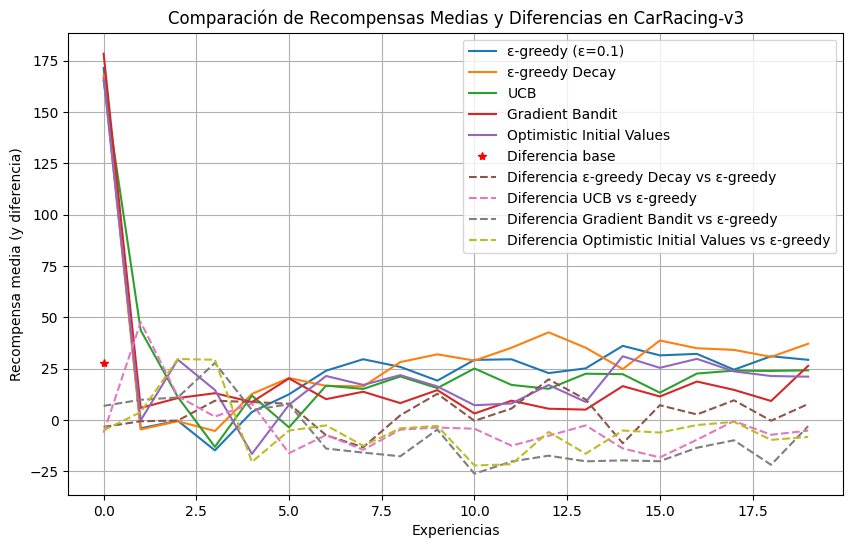

In [28]:
# === VISUALIZACIÓN DE RESULTADOS ===
# Paso 3: Gráficas comparativas al final
labels = ['ε-greedy (ε=0.1)', 'ε-greedy Decay', 'UCB', 'Gradient Bandit', 'Optimistic Initial Values']

# Gráfica de recompensas medias comparativas
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(recompensas_medias[i], label=labels[i])
plt.plot(0, np.mean(recompensas_medias[0]), 'r*', label='Diferencia base')  # Punto inicial como referencia
for i in range(1, 5):
    diff = recompensas_medias[i] - recompensas_medias[0]  # Diferencia respecto a ε-greedy
    plt.plot(range(turnos), diff, '--', label=f'Diferencia {labels[i]} vs ε-greedy')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media (y diferencia)')
plt.title('Comparación de Recompensas Medias y Diferencias en CarRacing-v3')
plt.show()

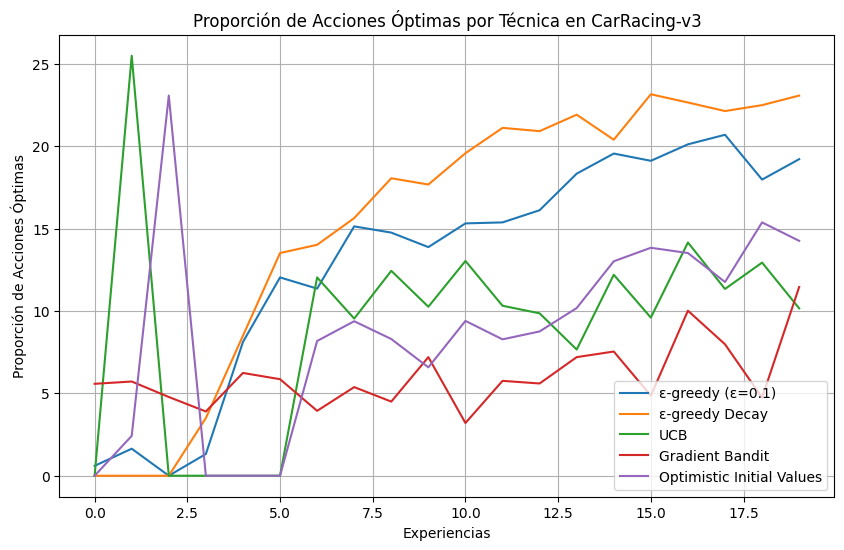

In [29]:
# Gráfica de proporción de acciones óptimas
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(acciones_optimas[i], label=labels[i])
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Proporción de Acciones Óptimas')
plt.title('Proporción de Acciones Óptimas por Técnica en CarRacing-v3')
plt.show()

In [31]:
# Paso 4: Determinación del mejor método
mejor_metodo_idx = np.argmax(np.mean(recompensas_medias, axis=1))
mejor_metodo = labels[mejor_metodo_idx]
print(f"\n=== RESULTADO FINAL ===")
print(f"El mejor método según la recompensa media es: {mejor_metodo}")
# === FINALIZACIÓN ===
env.close()


=== RESULTADO FINAL ===
El mejor método según la recompensa media es: ε-greedy Decay


In [32]:
# === EXPLICACIÓN DE LAS TÉCNICAS ===
print("\n=== EXPLICACIÓN DE LAS TÉCNICAS ===")
print("Entorno: CarRacing-v3 (Gymnasium)")
print("   - Descripción: El agente controla un coche en una pista, con acciones discretas (5 opciones definidas).")
print("   - Discretización: Convertimos el espacio continuo en 5 acciones: izquierda+acelerar, derecha+acelerar, recto, frenar, nada.")
print("   - Recompensas: Suma de la recompensa del entorno y un valor simulado de q*(a) con ruido normal (media q*(a), desv. 1).")
print("\n1. ε-greedy:")
print("   - Mecanismo: Selecciona la acción con mayor valor estimado Q(a) con probabilidad (1 - epsilon), o una acción aleatoria con probabilidad epsilon.")
print("   - Hiperparámetros: epsilon = 0.1, alpha_eg = 0.5.")
print("2. ε-greedy Decreciente:")
print("   - Mecanismo: Similar a ε-greedy, pero epsilon decae linealmente.")
print("   - Hiperparámetros: epsilon_inicial = 0.1, alpha_eg_decay = 0.5.")
print("3. UCB:")
print("   - Mecanismo: Elige acciones basadas en Q(a) + c * sqrt(ln(t) / N(a)).")
print("   - Hiperparámetros: c_ucb = 2.0, alpha_ucb = 0.5.")
print("4. Gradient Bandit:")
print("   - Mecanismo: Usa preferencias H(a) y softmax para seleccionar acciones.")
print("   - Hiperparámetros: alpha_grad = 0.1, baseline = True.")
print("5. Optimistic Initial Values:")
print("   - Mecanismo: Inicializa Q(a) con valores altos para fomentar exploración inicial.")
print("   - Hiperparámetros: Q_init = 5.0, alpha_opt = 0.5.")
print("\nNotas:")
print("   - Parámetros: partidas=50, turnos=20, semilla=42.")
print("   - Resultados: Gráficas individuales por método y comparativas muestran recompensa media y proporción de acciones óptimas.")


=== EXPLICACIÓN DE LAS TÉCNICAS ===
Entorno: CarRacing-v3 (Gymnasium)
   - Descripción: El agente controla un coche en una pista, con acciones discretas (5 opciones definidas).
   - Discretización: Convertimos el espacio continuo en 5 acciones: izquierda+acelerar, derecha+acelerar, recto, frenar, nada.
   - Recompensas: Suma de la recompensa del entorno y un valor simulado de q*(a) con ruido normal (media q*(a), desv. 1).

1. ε-greedy:
   - Mecanismo: Selecciona la acción con mayor valor estimado Q(a) con probabilidad (1 - epsilon), o una acción aleatoria con probabilidad epsilon.
   - Hiperparámetros: epsilon = 0.1, alpha_eg = 0.5.
2. ε-greedy Decreciente:
   - Mecanismo: Similar a ε-greedy, pero epsilon decae linealmente.
   - Hiperparámetros: epsilon_inicial = 0.1, alpha_eg_decay = 0.5.
3. UCB:
   - Mecanismo: Elige acciones basadas en Q(a) + c * sqrt(ln(t) / N(a)).
   - Hiperparámetros: c_ucb = 2.0, alpha_ucb = 0.5.
4. Gradient Bandit:
   - Mecanismo: Usa preferencias H(a) y softm